In [9]:
#### IMPORTING LIBRARIES ####
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile 
from scipy.signal import chirp, spectrogram
from scipy.optimize import minimize
import IPython
from playsound import playsound 
import simpleaudio as sa


In [19]:
#### GENERATING THE SINE SWEEP ####
w1 = 1
w2 = 1
fs = 44100
T = 1
t = np.linspace(0,T,T*fs)
sweep = np.sin((w1*T/np.log(w2/w1))*(np.exp((t/T)*np.log(w2/w1)) - 1))
audio = sweep * (2**15 - 1) / np.max(np.abs(sweep))
audio = audio.astype(np.int16)

<ipython-input-19-3455b186bd1d>:7: RuntimeWarning: divide by zero encountered in double_scalars
  sweep = np.sin((w1*T/np.log(w2/w1))*(np.exp((t/T)*np.log(w2/w1)) - 1))
<ipython-input-19-3455b186bd1d>:7: RuntimeWarning: invalid value encountered in multiply
  sweep = np.sin((w1*T/np.log(w2/w1))*(np.exp((t/T)*np.log(w2/w1)) - 1))


In [35]:
fs, audio = wavfile.read("examples_input_samples_cmu_arctic_us_axb_a0006.wav")

In [21]:
#play_obj = sa.play_buffer(audio, 1, 2, fs)
#play_obj.wait_done()
wavfile.write('sweep3266641.wav', fs, audio)
#playsound('sweep3266641.wav')

/Users/dannydreamt/miniconda3/lib/python3.8/site-packages/pyroomacoustics/room.py:1048: UserWarning: Using absorption parameter is deprecated. In the future, use materials instead.
  warnings.warn(
/Users/dannydreamt/miniconda3/lib/python3.8/site-packages/pyroomacoustics/room.py:1412: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = a3.Axes3D(fig)


(0.0, 4.0)

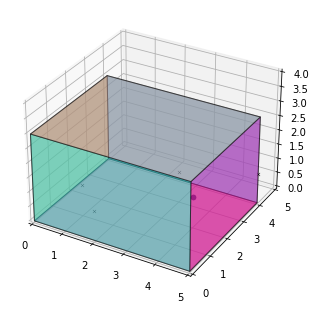

In [100]:
#### DESIGNING THE ROOM ####

pol = np.array([[0,0], [0,4], [5,4], [5,0]]).T
room = pra.Room.from_corners(pol, fs=16000, max_order=10, absorption=0.1)
room.extrude(3)
# Adding the source
Xsource = np.array([4])
Ysource = np.array([2])
Zsource = np.array([1])
room.add_source(np.array([Xsource, Ysource,Zsource]), signal= 'examples_input_samples_cmu_arctic_us_axb_a0006.wav')

# Adding the microphone
Xmics = [3,5,2,1]
Ymics =[3,4,0,1]
Zmics = [1,1,1,1]
R = np.array([Xmics,Ymics,Zmics])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_zlim([0,4])

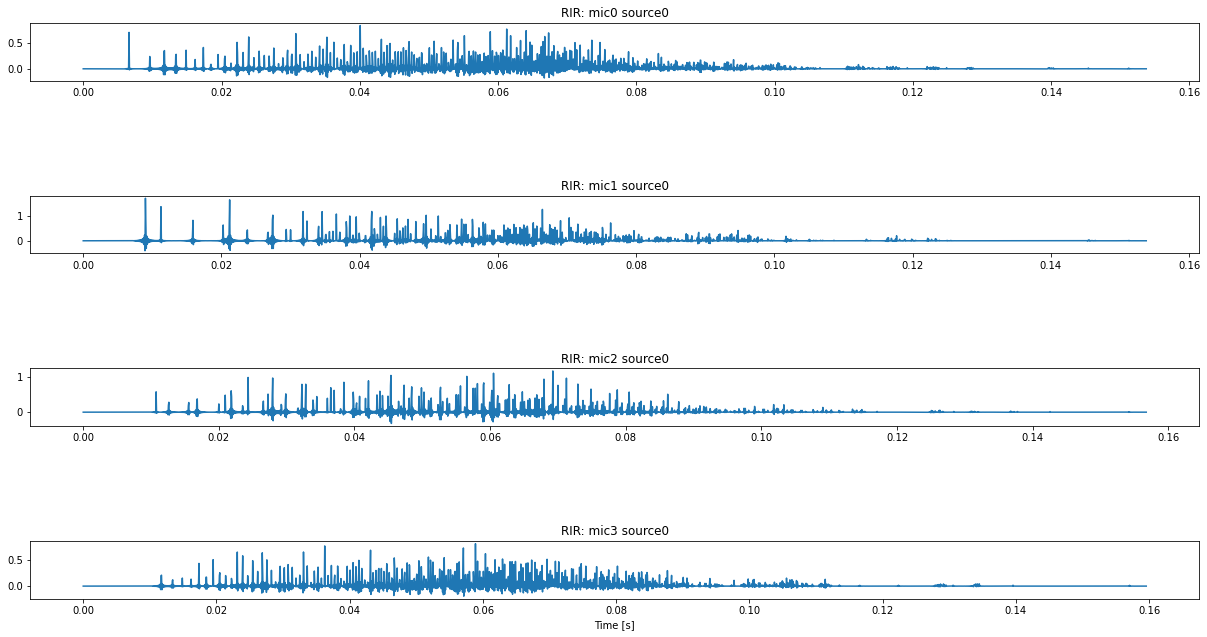

In [101]:
#### COMPUTING RIR ####
RIR = room.compute_rir()
# Plot and apply the RIR on the audio file
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
RIRR = plt.show()
#room.simulate()
#room.mic_array.to_wav('aaa.wav', norm=True, bitdepth=np.int16)

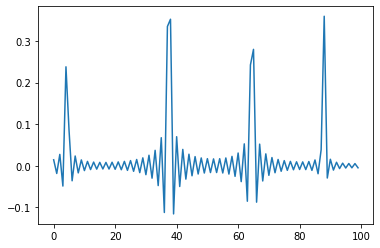

In [102]:

plt.plot(room.rir[0][0][150:250])

In [103]:
IPython.display.Audio(audio, rate = fs)

In [104]:
room.simulate()
IPython.display.Audio(room.mic_array.signals[1,:], rate = fs)

ValueError: in1 and in2 should have the same dimensionality

In [105]:
#### Computing time of first reflection ####
time = 0;
for n in range(1,len(room.rir[1][0]) - 1):
    if ((room.rir[0][0][n - 1] < room.rir[0][0][n]) & (room.rir[0][0][n + 1] < room.rir[0][0][n]) & (room.rir[0][0][n] > np.mean(room.rir[0][0]))):
        time = n/16000;
        print('Room Impulse Response empieza en: ', time, 'segundos')
        print('Muestra numero:', n)
        break;

Room Impulse Response empieza en:  0.006625 segundos
Muestra numero: 106


In [106]:
#### Computing distance between mic and speaker ####
## Si obtenemos la distancia teniendo en cuenta el primer valor
## que no es 0 en el RIR, no hay que restar al tiempo un valor
## delta.
Xmics_ = np.asarray(Xmics)
Ymics_ = np.asarray(Ymics)
Zmics_ = np.asarray(Zmics)
c = 343.2 #Velocidad del sonido en m/s
delta = 0.0025 #Delay del aparato (2 ms)
distance = (time -delta )* c;
distance_real = []
for i in range(0, len(Xmics)):
    distance_real.append(np.sqrt(abs(Xsource - Xmics_[i])**2 + abs(Ysource - Ymics_[i])**2))
print('Distancia real entre micro0 y altavoz:', distance_real[0], 'metros');
print('Distancia real entre micro1 y altavoz:', distance_real[1], 'metros');
print('Distancia real entre micro2 y altavoz:', distance_real[2], 'metros');
print('Distancia real entre micro3 y altavoz:', distance_real[3], 'metros');
print('Distancia mediante RIR entre micrófono y altavoz:', distance, 'metros') 

Distancia real entre micro0 y altavoz: [1.41421356] metros
Distancia real entre micro1 y altavoz: [2.23606798] metros
Distancia real entre micro2 y altavoz: [2.82842712] metros
Distancia real entre micro3 y altavoz: [3.16227766] metros
Distancia mediante RIR entre micrófono y altavoz: 1.4157 metros


In [107]:
    P = []
    for i in range(0, len(Xmics)):
        P.append((np.sqrt(abs(3 - Xmics[i])**2 + abs(3 - Ymics[i])**2)))
        
P

[0.0, 2.23606797749979, 3.1622776601683795, 2.8284271247461903]

In [118]:
def fun2(x1):
  
    P = [0,0,0,0];
    D = [0,0,0,0];
    for i in range(0, len(Xmics)):
        P[i] = (np.sqrt(abs(x1[0] - Xmics_[i])**2 + abs(x1[1] - Ymics_[i])**2))
        D[i] = (np.sqrt(abs(sum(Xsource) - Xmics_[i])**2 + abs(sum(Ysource) - Ymics_[i])**2))
    P = np.array(P).T
    D = np.array(D).T
    print(P)
    print(D)
    #P = [(np.sqrt(abs(x1[0] - Xmics[0])**2 + abs(x1[1] - Ymics[0])**2)), (np.sqrt(abs(x1[0] - Xmics[1])**2 + abs(x1[1] - Ymics[1])**2)), (np.sqrt(abs(x1[0] - Xmics[2])**2 + abs(x1[1] - Ymics[2])**2)),(np.sqrt(abs(x1[0] - Xmics[3])**2 + abs(x1[1] - Ymics[3])**2))]
    #D = [distance_real[0], distance_real[1],distance_real[2],distance_real[3]]
    return sum((P - D)**2);
bndsM = ((0,5),(0,4))
resM = minimize(fun2, (2,2), method='SLSQP', bounds=bndsM)
fun2([3,4])
print(resM)

[1.41421356 3.60555128 2.         1.41421356]
[1.41421356 2.23606798 2.82842712 3.16227766]
[1.41421355 3.60555126 2.         1.41421357]
[1.41421356 2.23606798 2.82842712 3.16227766]
[1.41421355 3.60555127 2.00000001 1.41421357]
[1.41421356 2.23606798 2.82842712 3.16227766]
[2.23606798 0.         5.         5.        ]
[1.41421356 2.23606798 2.82842712 3.16227766]
[0.27806995 2.23879633 2.98338332 2.76743839]
[1.41421356 2.23606798 2.82842712 3.16227766]
[0.27806996 2.23879632 2.98338332 2.76743841]
[1.41421356 2.23606798 2.82842712 3.16227766]
[0.27806994 2.23879632 2.98338333 2.7674384 ]
[1.41421356 2.23606798 2.82842712 3.16227766]
[2.27434989 2.08289769 3.56023612 4.10378808]
[1.41421356 2.23606798 2.82842712 3.16227766]
[1.11833556 1.9227347  3.08289384 3.25501321]
[1.41421356 2.23606798 2.82842712 3.16227766]
[1.11833557 1.92273469 3.08289385 3.25501322]
[1.41421356 2.23606798 2.82842712 3.16227766]
[1.11833555 1.92273468 3.08289385 3.25501322]
[1.41421356 2.23606798 2.82842712 

In [90]:
def fun2(x1):
    P = np.array([(np.sqrt(abs(x1[0] - x_mic0)**2 + abs(x1[1] - y_mic0)**2)), (np.sqrt(abs(x1[0] - x_mic1)**2 + abs(x1[1] - y_mic1)**2))])
    D = np.array([distance_real0, distance_real1])
    return sum((P - D)**2);

fun2([3.8,2.4])

NameError: name 'x_mic0' is not defined

In [ ]:
np.sqrt(abs(-0.12831171 - x_mic0)**2 + abs(0.39109573 - y_mic0)**2)
print(np.sqrt(abs(0 - x_mic0)**2 + abs(0 - y_mic0)**2))
print(np.sqrt(abs(0 - x_mic0)**2 + abs(2.00000024 - y_mic0)**2))